In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics.classification import BinaryAccuracy





In [2]:

df_raw = pd.read_csv("seismic.csv", header=None)
df_raw[18] = df_raw[18].apply(lambda x: 'A' if x ==1 else 'B')
# CLASS A = 1 & CLASS B = -1
df_raw

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,0.0,0,0.005633,0.006864,0.019389,0.018201,0.0,0.111111,0.0,0.142857,0.0,0,0,0,0,0.004975,0.0050,A
1,0,0.0,0,0.003063,0.006200,0.011186,0.019272,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,0.000000,0.0000,A
2,0,0.0,0,0.011065,0.037422,0.054437,0.145610,0.0,0.111111,0.0,0.142857,0.0,0,0,0,0,0.007463,0.0075,A
3,0,0.0,0,0.004831,0.012179,0.024609,0.047109,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,0.000000,0.0000,A
4,0,0.0,1,0.024527,0.042737,0.017151,0.033191,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,0.000000,0.0000,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362,1,0.0,1,0.031327,0.173384,0.393736,0.264454,0.5,0.000000,0.0,0.000000,0.0,0,0,0,0,0.000000,0.0000,A
2363,1,0.0,1,0.016185,0.122453,0.230425,0.229122,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,0.000000,0.0000,A
2364,1,0.0,1,0.010348,0.119132,0.146905,0.222698,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,0.000000,0.0000,A
2365,0,0.0,1,0.006176,0.070859,0.073080,0.104925,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,0.000000,0.0000,A


In [3]:
device = "cpu"

In [4]:
y = pd.get_dummies(df_raw.iloc[:,-1:])

y = torch.Tensor(y.values)
y

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [5]:
x = pd.DataFrame(df_raw.iloc[:,:-1])

#x = (x - x.min()) / (x.max() - x.min())

x = torch.Tensor(x.values)

x

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0050, 0.0050],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0075, 0.0075],
        ...,
        [1.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [6]:
class Autoencoder(nn.Module):
    # Layers is an array of integers representing the encoder architecture
    # Example: 30 --> 3 --> 30: layers = [30, 3]
    def __init__(self, layers):
        super().__init__()
        self.in_dim = layers[0]
        self.activation = nn.Sigmoid()
        self.layers = layers
        
        # Encoder
        self.encoder_layers = []
        
        for i in range(len(layers) - 1):
            self.encoder_layers.append(nn.Linear(layers[i], layers[i+1]))
            self.encoder_layers.append(nn.Sigmoid())
        
        self.encoder_sequence = nn.Sequential(*self.encoder_layers)
            
        # Decoder
        self.decoder_layers = []
        
#         for i in range(len(layers) - 1, 0, -1):
#             self.decoder_layers.append(nn.Linear(layers[i], layers[i - 1]))
#             self.decoder_layers.append(nn.Sigmoid())
    
#         layers.reverse()
#         for i in range(len(layers) - 1):
#             self.decoder_layers.append(nn.Linear(layers[i], layers[i+1]))
#             self.decoder_layers.append(nn.Sigmoid())

        reversed_layers = sorted(layers, reverse=False)
        for i in range(len(reversed_layers) - 1):
            self.decoder_layers.append(nn.Linear(reversed_layers[i], reversed_layers[i+1]))
            self.decoder_layers.append(nn.Sigmoid())
        
        self.decoder_sequence = nn.Sequential(*self.decoder_layers)
        
    def encode(self, x):
        return self.encoder_sequence(x)
    
    def decode(self, x):
        return self.decoder_sequence(x)
    
    def forward(self, x):
        x = self.encode(x)
        y = self.decode(x)
        return y

In [7]:
model_auto = Autoencoder([18, 13, 8, 5])

print(model_auto)

Autoencoder(
  (activation): Sigmoid()
  (encoder_sequence): Sequential(
    (0): Linear(in_features=18, out_features=13, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=13, out_features=8, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=8, out_features=5, bias=True)
    (5): Sigmoid()
  )
  (decoder_sequence): Sequential(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=8, out_features=13, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=13, out_features=18, bias=True)
    (5): Sigmoid()
  )
)


In [8]:
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

In [9]:
learning_rate = 0.00001
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_auto.parameters(), lr=learning_rate)
batch_size = 5

In [10]:
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# use Dataloader for Autoencoder 
custom_dataset = AutoencoderDataset(x)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 50
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model_auto,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model_auto.state_dict() }

    torch.save(state, "autoencoderarn.pth")

Epoch: 0


100%|██████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 250.82it/s, loss=0.23]


Ave Loss: 0.2208052849090552
Epoch: 1


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 257.24it/s, loss=0.222]


Ave Loss: 0.21349015894821424
Epoch: 2


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 270.39it/s, loss=0.214]


Ave Loss: 0.20637499695085776
Epoch: 3


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 261.71it/s, loss=0.207]


Ave Loss: 0.19941974880826122
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 256.02it/s, loss=0.2]


Ave Loss: 0.19261149574809938
Epoch: 5


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 279.71it/s, loss=0.192]


Ave Loss: 0.1859429352897129
Epoch: 6


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 261.63it/s, loss=0.185]


Ave Loss: 0.17940930295971375
Epoch: 7


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 257.09it/s, loss=0.178]


Ave Loss: 0.17300760132979742
Epoch: 8


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 259.00it/s, loss=0.171]


Ave Loss: 0.16673658873084224
Epoch: 9


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:02<00:00, 212.03it/s, loss=0.165]


Ave Loss: 0.16059686504461596
Epoch: 10


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:02<00:00, 201.74it/s, loss=0.158]


Ave Loss: 0.15459032724552516
Epoch: 11


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 259.37it/s, loss=0.152]


Ave Loss: 0.14871961225751584
Epoch: 12


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 298.84it/s, loss=0.145]


Ave Loss: 0.1429876323302084
Epoch: 13


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 293.60it/s, loss=0.139]


Ave Loss: 0.13739794986283227
Epoch: 14


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 290.32it/s, loss=0.133]


Ave Loss: 0.1319553079987377
Epoch: 15


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 314.19it/s, loss=0.127]


Ave Loss: 0.12666524385538283
Epoch: 16


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 309.05it/s, loss=0.121]


Ave Loss: 0.12153345237992987
Epoch: 17


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 300.93it/s, loss=0.116]


Ave Loss: 0.11656528352936611
Epoch: 18


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 300.93it/s, loss=0.111]


Ave Loss: 0.11176542711408832
Epoch: 19


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 305.80it/s, loss=0.105]


Ave Loss: 0.10713783780482247
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 282.31it/s, loss=0.1]


Ave Loss: 0.10268573335643057
Epoch: 21


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 298.03it/s, loss=0.0956]


Ave Loss: 0.09841156758776697
Epoch: 22


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 302.58it/s, loss=0.091]


Ave Loss: 0.09431696022990384
Epoch: 23


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 299.13it/s, loss=0.0866]


Ave Loss: 0.0904026290692609
Epoch: 24


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 319.23it/s, loss=0.0824]


Ave Loss: 0.08666839665941549
Epoch: 25


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 314.97it/s, loss=0.0783]


Ave Loss: 0.08311331933875124
Epoch: 26


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 281.34it/s, loss=0.0745]


Ave Loss: 0.0797358023372129
Epoch: 27


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 272.26it/s, loss=0.0708]


Ave Loss: 0.07653361689377938
Epoch: 28


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 249.30it/s, loss=0.0673]


Ave Loss: 0.07350398173343532
Epoch: 29


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:02<00:00, 236.63it/s, loss=0.064]


Ave Loss: 0.07064361529982795
Epoch: 30


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 250.65it/s, loss=0.0608]


Ave Loss: 0.06794878599167122
Epoch: 31


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:02<00:00, 232.94it/s, loss=0.0579]


Ave Loss: 0.06541535293659832
Epoch: 32


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:02<00:00, 229.94it/s, loss=0.0551]


Ave Loss: 0.06303873947401087
Epoch: 33


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 257.66it/s, loss=0.0524]


Ave Loss: 0.060814002552364445
Epoch: 34


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 252.50it/s, loss=0.0499]


Ave Loss: 0.058735809552204254
Epoch: 35


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 243.94it/s, loss=0.0476]


Ave Loss: 0.05679856306767162
Epoch: 36


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 263.65it/s, loss=0.0454]


Ave Loss: 0.054996403979475486
Epoch: 37


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 246.10it/s, loss=0.0434]


Ave Loss: 0.053323277456976695
Epoch: 38


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 265.12it/s, loss=0.0415]


Ave Loss: 0.05177300796698669
Epoch: 39


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 257.21it/s, loss=0.0397]


Ave Loss: 0.050339340244101576
Epoch: 40


100%|█████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 250.85it/s, loss=0.038]


Ave Loss: 0.049015986595601475
Epoch: 41


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 260.40it/s, loss=0.0365]


Ave Loss: 0.04779667126698584
Epoch: 42


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 247.23it/s, loss=0.0351]


Ave Loss: 0.0466751596548512
Epoch: 43


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 247.00it/s, loss=0.0337]


Ave Loss: 0.04564531225286707
Epoch: 44


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 251.38it/s, loss=0.0325]


Ave Loss: 0.044701126577010385
Epoch: 45


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 238.46it/s, loss=0.0314]


Ave Loss: 0.043836758943581126
Epoch: 46


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 258.10it/s, loss=0.0303]


Ave Loss: 0.04304654878183005
Epoch: 47


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 272.32it/s, loss=0.0293]


Ave Loss: 0.042325070615119066
Epoch: 48


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 256.41it/s, loss=0.0284]


Ave Loss: 0.04166713515728838
Epoch: 49


100%|████████████████████████████████████████████████████████████████████████| 474/474 [00:01<00:00, 246.17it/s, loss=0.0276]

Ave Loss: 0.04106780466572519


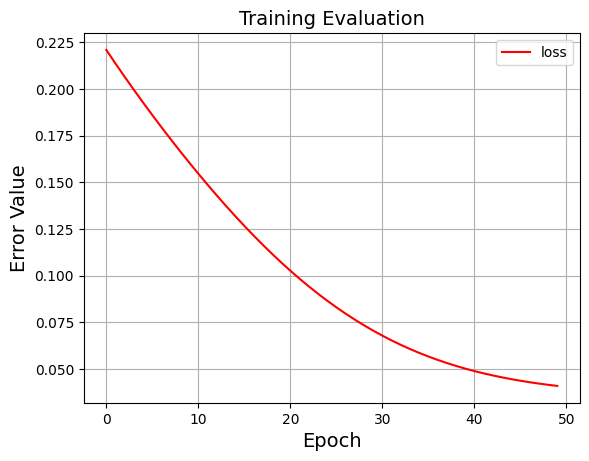

In [11]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [12]:
df_compressed_data = model_auto.encode(x)
#df_compressed_data = pd.DataFrame(df_compressed_data.detach().cpu().numpy())

df_compressed_data

tensor([[0.4023, 0.7295, 0.7046, 0.7627, 0.6164],
        [0.4022, 0.7294, 0.7045, 0.7625, 0.6164],
        [0.4022, 0.7296, 0.7051, 0.7633, 0.6169],
        ...,
        [0.4027, 0.7308, 0.7073, 0.7660, 0.6193],
        [0.4024, 0.7303, 0.7059, 0.7642, 0.6181],
        [0.4024, 0.7303, 0.7057, 0.7641, 0.6180]], grad_fn=<SigmoidBackward0>)

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 3) 
    
        
        self.multiple_layers = nn.Sequential(
            nn.Linear(3, 3),
            nn.Sigmoid(),
            nn.Linear(3, 3),
            nn.Sigmoid(),
            nn.Linear(3, 3),
            nn.Sigmoid(),
            nn.Linear(3, 3),
            nn.Sigmoid(),
        )
        
        self.output_layer = nn.Linear(3, self.out_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = self.activation(x)
        
        x = self.multiple_layers(x)
        
        y = self.output_layer(x)
        y = self.activation(y)
        
        return y

In [14]:
ratio = 0.8
test_size = 1 - ratio

x_train, x_test, y_train, y_test = train_test_split(df_compressed_data, y, test_size=test_size, random_state=0)

In [15]:
model_a = NeuralNetwork(5, 2)
predictions = model_a.forward(x_train)
predictions

tensor([[0.4653, 0.5545],
        [0.4653, 0.5545],
        [0.4653, 0.5545],
        ...,
        [0.4653, 0.5545],
        [0.4653, 0.5545],
        [0.4653, 0.5545]], grad_fn=<SigmoidBackward0>)

In [16]:
def one_hot_encoding(nd_array):
    one_hot_encoding_predictions = nd_array

    for i in range(len(nd_array)):
        max_pred = max(nd_array[i])

        for j in range(len(nd_array[i])):
            one_hot_encoding_predictions[i][j] = 1 if nd_array[i][j] == max_pred else 0

    return one_hot_encoding_predictions

predictions = one_hot_encoding(predictions)
predictions

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]], grad_fn=<CopySlices>)

In [17]:
learning_rate = 0.001
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_a.parameters(), lr = learning_rate)
batch_size = 5 #faster training, high mem consumption

In [18]:
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [19]:
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00 
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model_a.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
x_train = x_train.clone().detach()
y_train = y_train.clone().detach()
custom_dataset = MyCustomDataset(x=x_train, y=y_train)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
    
)

epochs = 75
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model_a,
        optimizer,
        loss_fn,
        batch_size
        
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model_a.state_dict() }

    torch.save(state, "seismic.pth")

Epoch: 0


100%|█████████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 266.46it/s, loss=0.085]


Ave Loss: 0.1822808376245574
Epoch: 1


100%|████████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 279.55it/s, loss=0.0317]


Ave Loss: 0.08267533923634439
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 283.73it/s, loss=0.0172]


Ave Loss: 0.06249387688089487
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 270.77it/s, loss=0.0113]


Ave Loss: 0.057060617533337944
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 267.74it/s, loss=0.00828]


Ave Loss: 0.055025939996744995
Epoch: 5


100%|████████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 280.91it/s, loss=0.0065]


Ave Loss: 0.054125533466249466
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 282.12it/s, loss=0.00537]


Ave Loss: 0.05369340066151757
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 263.64it/s, loss=0.00462]


Ave Loss: 0.05347965483855958
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 262.04it/s, loss=0.00412]


Ave Loss: 0.05337460019004023
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 269.22it/s, loss=0.00378]


Ave Loss: 0.053324862339074346
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 247.47it/s, loss=0.00355]


Ave Loss: 0.05330293323896275
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 244.41it/s, loss=0.00341]


Ave Loss: 0.05329441742622601
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 241.23it/s, loss=0.00332]


Ave Loss: 0.05329194165382898
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 245.62it/s, loss=0.00326]


Ave Loss: 0.053291914870933016
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 226.97it/s, loss=0.00323]


Ave Loss: 0.0532927143683603
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 248.67it/s, loss=0.00321]


Ave Loss: 0.05329367086060326
Epoch: 16


100%|████████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 254.31it/s, loss=0.0032]


Ave Loss: 0.05329453906764357
Epoch: 17


100%|████████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 242.90it/s, loss=0.0032]


Ave Loss: 0.053295251730913026
Epoch: 18


100%|████████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 260.40it/s, loss=0.0032]


Ave Loss: 0.05329580522464259
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 255.96it/s, loss=0.00319]


Ave Loss: 0.05329622270964519
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 247.30it/s, loss=0.00319]


Ave Loss: 0.05329652809990093
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 247.06it/s, loss=0.00319]


Ave Loss: 0.05329674725619816
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 246.52it/s, loss=0.00319]


Ave Loss: 0.05329690249587623
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 261.22it/s, loss=0.00319]


Ave Loss: 0.05329700789505267
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 248.73it/s, loss=0.00319]


Ave Loss: 0.05329707905153761
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 248.82it/s, loss=0.00319]


Ave Loss: 0.0532971261337026
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 265.25it/s, loss=0.00319]


Ave Loss: 0.0532971540279195
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 249.19it/s, loss=0.00319]


Ave Loss: 0.05329717053063607
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 252.79it/s, loss=0.00319]


Ave Loss: 0.053297178104082445
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 260.07it/s, loss=0.00319]


Ave Loss: 0.05329717884803471
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 246.79it/s, loss=0.00319]


Ave Loss: 0.05329717600307769
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 260.32it/s, loss=0.00319]


Ave Loss: 0.05329716923255916
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 265.89it/s, loss=0.00319]


Ave Loss: 0.053297160638712524
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 267.13it/s, loss=0.00319]


Ave Loss: 0.053297150083313795
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 240.92it/s, loss=0.00319]


Ave Loss: 0.053297137984720924
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 262.74it/s, loss=0.00319]


Ave Loss: 0.05329712592790242
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 264.36it/s, loss=0.00319]


Ave Loss: 0.053297112908430574
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 251.62it/s, loss=0.00319]


Ave Loss: 0.05329709941469683
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 252.38it/s, loss=0.00319]


Ave Loss: 0.053297084955852427
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 260.98it/s, loss=0.00319]


Ave Loss: 0.05329707108492076
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 256.18it/s, loss=0.00319]


Ave Loss: 0.05329705719064459
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 256.56it/s, loss=0.00319]


Ave Loss: 0.053297042619378
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 271.36it/s, loss=0.00319]


Ave Loss: 0.053297028336845985
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 271.71it/s, loss=0.00319]


Ave Loss: 0.05329701496782101
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 241.90it/s, loss=0.00319]


Ave Loss: 0.05329700073382097
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 266.88it/s, loss=0.00319]


Ave Loss: 0.05329698720384183
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 266.31it/s, loss=0.00319]


Ave Loss: 0.053296973219259317
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 242.58it/s, loss=0.00319]


Ave Loss: 0.053296959993372965
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 265.57it/s, loss=0.00319]


Ave Loss: 0.053296947308096025
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 266.14it/s, loss=0.00319]


Ave Loss: 0.05329693394091403
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 254.84it/s, loss=0.00319]


Ave Loss: 0.05329692086738124
Epoch: 51


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 233.62it/s, loss=0.00319]


Ave Loss: 0.053296908572203136
Epoch: 52


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 283.93it/s, loss=0.00319]


Ave Loss: 0.05329689667203849
Epoch: 53


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 282.16it/s, loss=0.00319]


Ave Loss: 0.05329688364826634
Epoch: 54


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 270.87it/s, loss=0.00319]


Ave Loss: 0.05329687220700537
Epoch: 55


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 236.36it/s, loss=0.00319]


Ave Loss: 0.053296860470252214
Epoch: 56


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 254.38it/s, loss=0.00319]


Ave Loss: 0.053296848433092237
Epoch: 57


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 249.49it/s, loss=0.00319]


Ave Loss: 0.05329683666316532
Epoch: 58


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 257.76it/s, loss=0.00319]


Ave Loss: 0.05329682597752886
Epoch: 59


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 269.94it/s, loss=0.00319]


Ave Loss: 0.05329681331068179
Epoch: 60


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 270.50it/s, loss=0.00319]


Ave Loss: 0.053296802586956946
Epoch: 61


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 259.92it/s, loss=0.00319]


Ave Loss: 0.05329679101668691
Epoch: 62


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 261.30it/s, loss=0.00319]


Ave Loss: 0.05329677947406168
Epoch: 63


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 264.09it/s, loss=0.00319]


Ave Loss: 0.05329676798672604
Epoch: 64


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 253.28it/s, loss=0.00319]


Ave Loss: 0.0532967568225274
Epoch: 65


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 258.04it/s, loss=0.00319]


Ave Loss: 0.0532967449444786
Epoch: 66


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 269.30it/s, loss=0.00319]


Ave Loss: 0.053296733970721905
Epoch: 67


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 274.07it/s, loss=0.00319]


Ave Loss: 0.05329672305286914
Epoch: 68


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 254.60it/s, loss=0.00319]


Ave Loss: 0.05329671117604899
Epoch: 69


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 262.55it/s, loss=0.00319]


Ave Loss: 0.053296700166046894
Epoch: 70


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 275.15it/s, loss=0.00319]


Ave Loss: 0.05329668824683806
Epoch: 71


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 250.45it/s, loss=0.00319]


Ave Loss: 0.0532966778929392
Epoch: 72


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 263.49it/s, loss=0.00319]


Ave Loss: 0.05329666632574081
Epoch: 73


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 263.26it/s, loss=0.00319]


Ave Loss: 0.05329665533724022
Epoch: 74


100%|███████████████████████████████████████████████████████████████████████| 379/379 [00:01<00:00, 265.98it/s, loss=0.00319]

Ave Loss: 0.05329664506811874


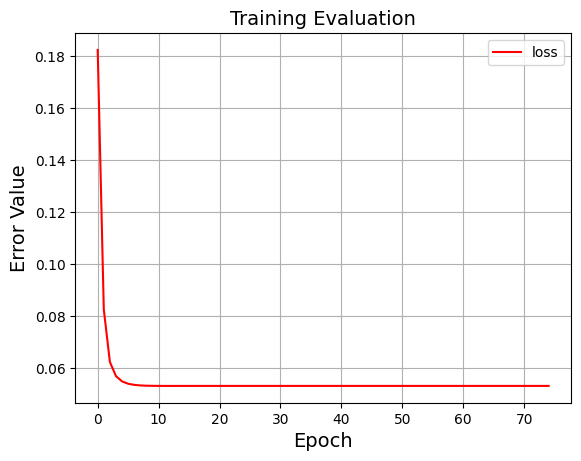

In [20]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [22]:
target = y_test
prediction = model_a.forward(x_test)
metric = BinaryAccuracy()
metric(prediction, target)

tensor(0.9620)